In [1]:
%matplotlib inline
%config Completer.use_jedi = False # to use autocomplete
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import os
import json
import pandas as pd
import sklearn
from random import seed
from sklearn.model_selection import KFold
from sklearn import linear_model, ensemble, neighbors, tree
from sklearn import metrics
from sklearn.neural_network import MLPRegressor
# from sklearn.preprocessing import PolynomialFeatures
# from texttable import Texttable
import scipy.optimize as optimization
RANDOM_SEED=0
seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
print(sklearn.__version__)
from itertools import combinations
from numpy.random import default_rng
import itertools
plt.rcdefaults()
# plt.rcParams.update({'font.family':'fantasy'})

0.24.2


In [2]:
def path_leaf(path): # get filename(with extension) from path
    head, tail = os.path.split(path)
    return tail or os.path.basename(head)


def file_in_folder(folder_path, flag=1): # get files in given folder, return list of filepath and filename
    file_list = []
    file_name = []
    for(dirpath, dirnames, filenames) in os.walk(folder_path):
#         print(filenames)
        
        for i in filenames:
            try:
                file_list += [dirpath + os.sep + i]
                file_name += [i]
            except:
                continue
        if flag == 0:
            break
        file_list.sort(key=path_leaf)
        file_name.sort()
    return [file_list, file_name]

In [10]:
res_dir = '../../prediction_code/mse_in_sample_lottery_transfer/in_sample'
all_folders = [os.path.join(res_dir, i) for i in os.listdir(res_dir)]

# get data

df = pd.read_csv('../../../data/PPP_normalized_pooled_data/30countries.csv')

a, b = np.unique(df['lottery'], return_counts=True)

useful_lottery_num = []
for i in range(b.shape[0]):
    if b[i] > 2900:
        useful_lottery_num.append(int(a[i]))
print(useful_lottery_num, len(useful_lottery_num))
# in total 24 lotteries
num_domains = len(useful_lottery_num)


all_params = ['a', 'b', 'd', 'g']
CPT_models = []
for i in range(1, len(all_params)+1):
    tmp = list(itertools.combinations(all_params, i))
    CPT_models += tmp
    
CPT_models = [''.join(i) for i in CPT_models]
CPT_models = ['g', 'ab', 'dg', 'abg', 'abdg']
# model_types = [model_types[-1]]
print(CPT_models)
ML_models = ['DT', 'RF', 'NN']
ML_models = ['Lasso', 'RF', 'NN']
ML_models = ['EU_iso', 'RF', 'kernel_ridge_rbf']
all_models = CPT_models + ML_models

[1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 23, 24, 25, 26, 27, 28, 30, 31, 32, 33, 34, 44] 24
['g', 'ab', 'dg', 'abg', 'abdg']


In [11]:
def get_in_sample(folder='../../prediction_code/mse_in_sample_lottery_transfer/in_sample'):
    in_sample_folders = os.listdir(folder)
    res = {}
    for cur_fol in in_sample_folders:
        file_list, file_name = file_in_folder(os.path.join(folder, cur_fol))
        file_list = [i for i in file_list if '.json' in i]
        file_name = [i for i in file_name if '.json' in i]
#         print(file_list)
        for file in file_list:
            with open(file, 'r') as f:
                content = json.load(f)
#             print(content)
            if cur_fol not in res.keys():
                res[cur_fol] = {}
#             print(file)
#             if '/EU' in file:
#                 tmp = 'EU'
#             else:
            tmp = content['model_type']
            res[cur_fol][tmp] = content['train_mse']
    print(res)
    return res

In [12]:
in_sample_res = get_in_sample()

{'32': {'EU_iso': 19.414447240494766, 'RF': 19.41445015230689, 'a': 19.900544959128066, 'ab': 19.414447240494766, 'abd': 19.414447240494766, 'abdg': 19.414447240494766, 'abg': 19.414447240494766, 'ad': 19.414447240494766, 'adg': 19.414447240494766, 'ag': 19.414447240494766, 'b': 19.414447240494766, 'bd': 19.414447240494766, 'bdg': 19.414447240494766, 'bg': 19.414447240494766, 'd': 19.414447240494766, 'dg': 19.414447240494766, 'g': 19.414447240494766, 'kernel_ridge_rbf': 19.41446339009145}, '34': {'EU_iso': 23.634347430701467, 'RF': 23.634355490034565, 'a': 27.910762942779293, 'ab': 23.634347430701467, 'abd': 23.634347430701467, 'abdg': 23.634347430701467, 'abg': 23.634347430701467, 'ad': 23.634347430701467, 'adg': 23.634347430701467, 'ag': 23.634347430701467, 'b': 23.634347430701467, 'bd': 23.634347430701467, 'bdg': 23.634347430701467, 'bg': 23.634347430701467, 'd': 23.634347430701467, 'dg': 23.634347430701467, 'g': 23.634347430701467, 'kernel_ridge_rbf': 23.63437503898285}, '33': {'EU

In [13]:
def get_round(a, digit=3):
    return round(a, digit)

def get_res(folder, normalize=False, in_sample_dic=None):
    file_list, file_name = file_in_folder(folder)
    file_list = [i for i in file_list if '.json' in i]
    file_name = [i for i in file_name if '.json' in i]
    print(file_list)
    res_dic = {'model': [], 'train_data': [], 'train_mse': []}
    train_data = folder.split('/')[1]
    for model_type in all_models:
        for file in file_list:
            file_type = path_leaf(file).split('.json')[0]
            if model_type == file_type:
                with open(file, 'r') as f:
                    content = json.load(f)
#                 print(content)
                res_dic['model'].append(content['model_type'])
                res_dic['train_data'].append(train_data)
                res_dic['train_mse'].append(get_round(content['train_mse']))
                for key, val in content['test_mse'].items():
                    # if key not in num_name_dic.keys():
                    #     continue
                    if key not in res_dic.keys():
                        res_dic[key] = []
                    if normalize:
                        res_dic[key].append(get_round(val/in_sample_dic[key][model_type]))
                    else:
                        res_dic[key].append(get_round(val))

#     print(res_dic)
    df = pd.DataFrame.from_dict(res_dic)
    display(df)
    print(df.to_latex(index=False))
    return res_dic

In [14]:
print(len(in_sample_res.keys()))
in_sample_res['31']

24


{'EU_iso': 17.008796856786745,
 'RF': 17.008821585049635,
 'a': 17.026396457765667,
 'ab': 17.026396457765667,
 'abd': 17.008796856786745,
 'abdg': 17.008796856786745,
 'abg': 17.008796856786745,
 'ad': 17.008796856786745,
 'adg': 17.008796856786745,
 'ag': 17.008796856786745,
 'b': 17.026396457765667,
 'bd': 17.008796856786745,
 'bdg': 17.008796856786745,
 'bg': 17.008796856786745,
 'd': 17.008796856786745,
 'dg': 17.008796856786745,
 'g': 17.008796856786745,
 'kernel_ridge_rbf': 17.00880361052676}

In [15]:
def get_index(arr, median_of):
    # median_of is 'min', 'max', or percentile (50, 75, 90, etc.)
    if median_of == 'max':
        return np.argmax(arr)
    elif median_of == 'min':
        return np.argmin(arr)
    else:
        percent = int(median_of)
        interpolation = 'higher'
        if percent < 50:
            interpolation = 'lower'
        val = np.percentile(arr, percent, interpolation=interpolation)
#         if val in arr:
#             print(1, val)
#         else:
#             print(0, val)
#             print(arr)
        if type(arr) == np.ndarray:
            return np.where(arr == val)[0][0]
        else:
            return arr.index(val)

def get_percentile(arr, median_of):
    # median_of is 'min', 'max', or percentile (50, 75, 90, etc.)
    if median_of == 'max':
        return np.max(arr)
    elif median_of == 'min':
        return np.min(arr)
    else:
        percent = int(median_of)
        interpolation = 'higher'
        if percent < 50:
            interpolation = 'lower'
        val = np.percentile(arr, percent, interpolation=interpolation)
        return val

def get_median_transfer_error(folder_list, all_contents=None, normalize=False, in_sample_dic=None, use_best_in_sample=False, median_of='max', 
                              median_of_list=None, model_to_see=None):
    print(model_to_see)
    if use_best_in_sample:
        best_in_sample_across_model = {}
        for key, val in in_sample_dic.items():
            best_in_sample_across_model[key] = {}

            best_in_sample = 1e10
            for model_type, cur_error in val.items():
                if model_type not in model_to_see:
                    continue
                if best_in_sample > cur_error:
                    best_in_sample = cur_error
            for model_type in val.keys():
                if model_type not in model_to_see:
                    continue
                best_in_sample_across_model[key][model_type] = best_in_sample
    else:
        best_in_sample_across_model = in_sample_dic
    
        
#     print(best_in_sample_across_model)
#     res_dic = {'model': [], 'train_data': [], 'train_mse': []}
    res_dic = {}
    all_res_dic = {}
    for folder in folder_list:
        print(folder)
        if path_leaf(folder) == '.DS_Store':# or int(path_leaf(folder)) not in num_name_dic.keys():
            continue
        file_list, file_name = file_in_folder(folder)
        file_list = [i for i in file_list if '.json' in i]
        file_name = [i for i in file_name if '.json' in i]
#         print(file_list)
        
        train_data = folder.split('/')[1]
        for model_type in model_to_see:
            if model_type not in res_dic.keys():
                res_dic[model_type] = {'train_data': [], 'transfer_domain': [], 'in_sample': [], 
                                       'raw_transfer': [], 'best_in_sample': [], 'transfer_ratio': []}
                all_res_dic[model_type] = {'train_data': [], 'transfer_domain': [], 'in_sample': [], 
                                       'raw_transfer': [], 'best_in_sample': [], 'transfer_ratio': []}
            for file in file_list:
                file_type = path_leaf(file).split('.json')[0]
                if model_type == file_type:
                    if all_contents is not None:
                        content = all_contents[file]
                    else:
                        with open(file, 'r') as f:
                            content = json.load(f)

                    all_transfer_domain = []
                    all_transfer_error_ratio = []
                    raw_transfer = []
                    in_sample = []
                    best_in_sample = []
                    for key, val in content['test_mse'].items():
#                         print(key, type(key))
                        # if int(key) not in num_name_dic.keys():
                        #     continue
                        all_transfer_domain.append(key)
                        raw_transfer.append(get_round(np.sqrt(val)))
                        in_sample.append(get_round(np.sqrt(in_sample_dic[key][model_type])))
                        best_in_sample.append(get_round(np.sqrt(best_in_sample_across_model[key][model_type])))
#                         all_transfer_error_ratio.append(get_round(best_in_sample_across_model[key][model_type]/val))
                        all_transfer_error_ratio.append(get_round(np.sqrt(val)/np.sqrt(best_in_sample_across_model[key][model_type])))
#                         if normalize:
#                             all_transfer_error_ratio.append(get_round(best_in_sample_across_model[key][model_type]/val))
#                         else:
#                             all_transfer_error_ratio.append(get_round(val))
                    
#                     print(len(all_transfer_domain))
                    if normalize:
                        list_to_find_index = all_transfer_error_ratio
                    else:
                        list_to_find_index = raw_transfer
#                     best_idx = np.argmax(raw_transfer)
                    best_idx = get_index(list_to_find_index, median_of=median_of)
#                     print(best_idx)
                    res_dic[model_type]['train_data'].append(train_data)
                    res_dic[model_type]['transfer_ratio'].append(all_transfer_error_ratio[best_idx])
                    res_dic[model_type]['transfer_domain'].append(all_transfer_domain[best_idx])
                    res_dic[model_type]['raw_transfer'].append(raw_transfer[best_idx])
                    res_dic[model_type]['in_sample'].append(in_sample[best_idx])
                    res_dic[model_type]['best_in_sample'].append(best_in_sample[best_idx])
                    
                    all_res_dic[model_type]['train_data'].append([train_data]*len(all_transfer_error_ratio))
                    all_res_dic[model_type]['transfer_ratio'].append(all_transfer_error_ratio)
                    all_res_dic[model_type]['transfer_domain'].append(all_transfer_domain)
                    all_res_dic[model_type]['raw_transfer'].append(raw_transfer)
                    all_res_dic[model_type]['in_sample'].append(in_sample)
                    all_res_dic[model_type]['best_in_sample'].append(best_in_sample)

    for key, val in all_res_dic.items():
        print(key, val['train_data'])
    print('111111')
    
    final_return = {}
    for median_of in median_of_list:
        print(median_of)
        res_dic = {}
        for model_type in model_to_see:
            if model_type not in res_dic.keys():
                res_dic[model_type] = {'train_data': [], 'transfer_domain': [], 'in_sample': [], 
                                       'raw_transfer': [], 'best_in_sample': [], 'transfer_ratio': []}
            
#             for i in range(len(all_res_dic[model_type]['train_data'])):
            print(model_type, len(all_res_dic[model_type]['train_data']))
            train_data = all_res_dic[model_type]['train_data'][0][0]
            all_transfer_domain = np.array(all_res_dic[model_type]['transfer_domain']).reshape(-1,)
            all_transfer_error_ratio = np.array(all_res_dic[model_type]['transfer_ratio']).reshape(-1,)
            raw_transfer = np.array(all_res_dic[model_type]['raw_transfer']).reshape(-1,)
            in_sample = np.array(all_res_dic[model_type]['in_sample']).reshape(-1,)
            best_in_sample = np.array(all_res_dic[model_type]['best_in_sample']).reshape(-1,)
#             print(all_transfer_domain.shape, all_transfer_error_ratio.shape, raw_transfer.shape, in_sample.shape, best_in_sample.shape)

            if normalize:
                list_to_find_index = all_transfer_error_ratio
            else:
                list_to_find_index = raw_transfer

            best_idx = get_index(list_to_find_index, median_of=median_of)

            res_dic[model_type]['train_data'].append(train_data)
            res_dic[model_type]['transfer_ratio'].append(all_transfer_error_ratio[best_idx])
            res_dic[model_type]['transfer_domain'].append(all_transfer_domain[best_idx])
            res_dic[model_type]['raw_transfer'].append(raw_transfer[best_idx])
            res_dic[model_type]['in_sample'].append(in_sample[best_idx])
            res_dic[model_type]['best_in_sample'].append(best_in_sample[best_idx])
            
            
            
        if normalize:
            sort_key = 'transfer_ratio'
        else:
            sort_key = 'raw_transfer'
        final_res = {'model': [], 'train_data': [], 'transfer_domain': [], 'in_sample': [], 'raw_transfer': [], 
                     'best_in_sample': [], 'transfer_ratio': []}
        only_median_res = {'model': [], 'median_transfer_error': []}
        for key, val in res_dic.items():
#             print(key)
            df = pd.DataFrame.from_dict(val)
#             print(df.shape)
#             display(df)
            final_res['model'].append(key)
            final_res['train_data'].append(df['train_data'].values[0])
            final_res['transfer_domain'].append(df['transfer_domain'].values[0])
            final_res['transfer_ratio'].append(df['transfer_ratio'].values[0])
            final_res['raw_transfer'].append(df['raw_transfer'].values[0])
            final_res['in_sample'].append(df['in_sample'].values[0])
            final_res['best_in_sample'].append(df['best_in_sample'].values[0])
    #         only_median_res['model'].append(key)
    #         only_median_res['median_transfer_error'].append(df['raw_transfer'].median())

#             if df.shape[0] % 2 == 1:
#                 tmp_rol = df.loc[df[sort_key]==df[sort_key].median()]

#                 tmp_df = df.sort_values(by=sort_key)
#                 left_idx = (tmp_df.shape[0] - 1) // 2
#                 tmp_rol = tmp_df.iloc[left_idx]

#                 final_res['model'].append(key)
#                 final_res['train_data'].append(tmp_rol['train_data'])
#                 final_res['transfer_domain'].append(tmp_rol['transfer_domain'])
#                 final_res['transfer_ratio'].append(tmp_rol['transfer_ratio'])
#                 final_res['raw_transfer'].append(tmp_rol['raw_transfer'])
#                 final_res['in_sample'].append(tmp_rol['in_sample'])
#                 final_res['best_in_sample'].append(tmp_rol['best_in_sample'])

#             else:
#     #             print(2)
#                 tmp_df = df.sort_values(by=sort_key)
#     #             if key == 'NN':
#     #                 display(tmp_df)
#     #             display(tmp_df[tmp_df['transfer_error'] < tmp_df['transfer_error'].median()].iloc[-1])
#                 left_idx = (tmp_df.shape[0] - 1) // 2
#                 right_idx = (tmp_df.shape[0] + 1) // 2
#     #             display(tmp_df[tmp_df['transfer_error'] < tmp_df['transfer_error'].median()].iloc[-1])
#     #             tmp_rol = tmp_df[tmp_df['transfer_ratio'] < tmp_df['transfer_ratio'].median()].iloc[-1]

#     #             tmp_rol = tmp_df.iloc[left_idx]
#     #             final_res['model'].append(key)
#     #             final_res['train_data'].append(tmp_rol['train_data'])
#     #             final_res['transfer_domain'].append(tmp_rol['transfer_domain'])
#     #             final_res['transfer_ratio'].append(tmp_rol['transfer_ratio'])
#     #             final_res['raw_transfer'].append(tmp_rol['raw_transfer'])
#     #             final_res['in_sample'].append(tmp_rol['in_sample'])
#     #             final_res['best_in_sample'].append(tmp_rol['best_in_sample'])

#     #             display(tmp_df[tmp_df['transfer_error'] > tmp_df['transfer_error'].median()].iloc[0])
#     #             tmp_rol = tmp_df[tmp_df['transfer_ratio'] > tmp_df['transfer_ratio'].median()].iloc[0]
#                 tmp_rol = tmp_df.iloc[right_idx]
#                 final_res['model'].append(key)
#                 final_res['train_data'].append(tmp_rol['train_data'])
#                 final_res['transfer_domain'].append(tmp_rol['transfer_domain'])
#                 final_res['transfer_ratio'].append(tmp_rol['transfer_ratio'])
#                 final_res['raw_transfer'].append(tmp_rol['raw_transfer'])
#                 final_res['in_sample'].append(tmp_rol['in_sample'])
#                 final_res['best_in_sample'].append(tmp_rol['best_in_sample'])


    #     print(final_res)
#         df = pd.DataFrame.from_dict(final_res)
#     display(df)
#     print(df.to_latex(index=False))
        final_return[median_of] = final_res[sort_key]
#     return final_res[sort_key]
    return final_return, res_dic

In [16]:
raw_transfer_dic, best_in_sample_across_model = get_median_transfer_error(all_folders, normalize=True, in_sample_dic=in_sample_res, 
                                                                          use_best_in_sample=True, median_of_list=['max', 95, 90, 75, 50, 25, 10, 5, 'min'], 
                                                                          model_to_see=CPT_models+ML_models)

['g', 'ab', 'dg', 'abg', 'abdg', 'EU_iso', 'RF', 'kernel_ridge_rbf']
../../prediction_code/mse_in_sample_lottery_transfer/in_sample/32
../../prediction_code/mse_in_sample_lottery_transfer/in_sample/34
../../prediction_code/mse_in_sample_lottery_transfer/in_sample/33
../../prediction_code/mse_in_sample_lottery_transfer/in_sample/27
../../prediction_code/mse_in_sample_lottery_transfer/in_sample/9
../../prediction_code/mse_in_sample_lottery_transfer/in_sample/11
../../prediction_code/mse_in_sample_lottery_transfer/in_sample/7
../../prediction_code/mse_in_sample_lottery_transfer/in_sample/6
../../prediction_code/mse_in_sample_lottery_transfer/in_sample/28
../../prediction_code/mse_in_sample_lottery_transfer/in_sample/1
../../prediction_code/mse_in_sample_lottery_transfer/in_sample/10
../../prediction_code/mse_in_sample_lottery_transfer/in_sample/26
../../prediction_code/mse_in_sample_lottery_transfer/in_sample/44
../../prediction_code/mse_in_sample_lottery_transfer/in_sample/31
../../predi

## For each training domain, find the specific transfer error.  Then report the median of the specific transfer errors, across training domains.

In [17]:
%%time
raw_transfer_dic = {}
median_of_list = ['max', 95, 90, 75, 50, 25, 10, 5, 'min']

raw_transfer_dic,_ = get_median_transfer_error(all_folders, normalize=False, in_sample_dic=in_sample_res, use_best_in_sample=False, median_of_list=median_of_list, model_to_see=CPT_models+ML_models)

['g', 'ab', 'dg', 'abg', 'abdg', 'EU_iso', 'RF', 'kernel_ridge_rbf']
../../prediction_code/mse_in_sample_lottery_transfer/in_sample/32
../../prediction_code/mse_in_sample_lottery_transfer/in_sample/34
../../prediction_code/mse_in_sample_lottery_transfer/in_sample/33
../../prediction_code/mse_in_sample_lottery_transfer/in_sample/27
../../prediction_code/mse_in_sample_lottery_transfer/in_sample/9
../../prediction_code/mse_in_sample_lottery_transfer/in_sample/11
../../prediction_code/mse_in_sample_lottery_transfer/in_sample/7
../../prediction_code/mse_in_sample_lottery_transfer/in_sample/6
../../prediction_code/mse_in_sample_lottery_transfer/in_sample/28
../../prediction_code/mse_in_sample_lottery_transfer/in_sample/1
../../prediction_code/mse_in_sample_lottery_transfer/in_sample/10
../../prediction_code/mse_in_sample_lottery_transfer/in_sample/26
../../prediction_code/mse_in_sample_lottery_transfer/in_sample/44
../../prediction_code/mse_in_sample_lottery_transfer/in_sample/31
../../predi

## For each training domain, find the MAX ratio normalized by best IN SAMPLE of ALL MODELS. Then report the median of the max ratios, across training domains.

In [18]:
%%time
best_normalize_dic = {}

best_normalize_dic,_ = get_median_transfer_error(all_folders, normalize=True, 
                                               in_sample_dic=in_sample_res, use_best_in_sample=True, median_of_list=median_of_list, model_to_see=CPT_models+ML_models)

['g', 'ab', 'dg', 'abg', 'abdg', 'EU_iso', 'RF', 'kernel_ridge_rbf']
../../prediction_code/mse_in_sample_lottery_transfer/in_sample/32
../../prediction_code/mse_in_sample_lottery_transfer/in_sample/34
../../prediction_code/mse_in_sample_lottery_transfer/in_sample/33
../../prediction_code/mse_in_sample_lottery_transfer/in_sample/27
../../prediction_code/mse_in_sample_lottery_transfer/in_sample/9
../../prediction_code/mse_in_sample_lottery_transfer/in_sample/11
../../prediction_code/mse_in_sample_lottery_transfer/in_sample/7
../../prediction_code/mse_in_sample_lottery_transfer/in_sample/6
../../prediction_code/mse_in_sample_lottery_transfer/in_sample/28
../../prediction_code/mse_in_sample_lottery_transfer/in_sample/1
../../prediction_code/mse_in_sample_lottery_transfer/in_sample/10
../../prediction_code/mse_in_sample_lottery_transfer/in_sample/26
../../prediction_code/mse_in_sample_lottery_transfer/in_sample/44
../../prediction_code/mse_in_sample_lottery_transfer/in_sample/31
../../predi

## For each training domain, find the MAX ratio normalized by MODEL IN SAMPLE. Then report the median of the max ratios, across training domains.

In [19]:
%%time
same_model_normalize_dic = {}

same_model_normalize_dic,_ = get_median_transfer_error(all_folders, normalize=True, 
                                                     in_sample_dic=in_sample_res, use_best_in_sample=False, median_of_list=median_of_list, model_to_see=CPT_models+ML_models)

['g', 'ab', 'dg', 'abg', 'abdg', 'EU_iso', 'RF', 'kernel_ridge_rbf']
../../prediction_code/mse_in_sample_lottery_transfer/in_sample/32
../../prediction_code/mse_in_sample_lottery_transfer/in_sample/34
../../prediction_code/mse_in_sample_lottery_transfer/in_sample/33
../../prediction_code/mse_in_sample_lottery_transfer/in_sample/27
../../prediction_code/mse_in_sample_lottery_transfer/in_sample/9
../../prediction_code/mse_in_sample_lottery_transfer/in_sample/11
../../prediction_code/mse_in_sample_lottery_transfer/in_sample/7
../../prediction_code/mse_in_sample_lottery_transfer/in_sample/6
../../prediction_code/mse_in_sample_lottery_transfer/in_sample/28
../../prediction_code/mse_in_sample_lottery_transfer/in_sample/1
../../prediction_code/mse_in_sample_lottery_transfer/in_sample/10
../../prediction_code/mse_in_sample_lottery_transfer/in_sample/26
../../prediction_code/mse_in_sample_lottery_transfer/in_sample/44
../../prediction_code/mse_in_sample_lottery_transfer/in_sample/31
../../predi

# make tables

In [20]:
def make_tables(model, data, median_of_list):
    res = {'model': model}
    for median_of in median_of_list:
        res[median_of] = data[median_of]
#     res[f'lower_{lower_percent}'] = data[lower_percent]
#     res[f'higher_{higher_percent}'] = data[higher_percent]

    df = pd.DataFrame.from_dict(res)
    display(df)
    print(df.to_latex(index=False))
#     return res

In [21]:
make_tables(all_models, raw_transfer_dic, median_of_list)
make_tables(all_models, best_normalize_dic, median_of_list)
make_tables(all_models, same_model_normalize_dic, median_of_list)

,model,max,95,90,75,50,25,10,5,min
0,g,5.312,5.117,4.957,4.694,4.293,3.154,1.858,1.134,1.034
1,ab,16.180,6.297,5.615,5.117,4.504,3.453,1.882,1.134,1.034
2,dg,7.151,5.379,5.154,4.828,4.410,3.283,1.868,1.132,0.969
3,abg,16.180,6.518,5.545,5.057,4.461,3.470,1.937,1.134,1.034
4,abdg,16.180,6.802,6.144,5.214,4.625,3.472,2.015,1.311,0.989
5,EU_iso,10.097,5.607,5.312,5.033,4.535,3.164,1.854,1.126,0.968
6,RF,40.513,30.296,27.082,20.643,12.559,7.013,4.822,4.351,1.844
7,kernel_ridge_rbf,24.988,19.311,16.180,14.299,8.916,5.983,4.581,3.021,2.886


\begin{tabular}{lrrrrrrrrr}
\toprule
           model &    max &     95 &     90 &     75 &     50 &    25 &    10 &     5 &   min \\
\midrule
               g &  5.312 &  5.117 &  4.957 &  4.694 &  4.293 & 3.154 & 1.858 & 1.134 & 1.034 \\
              ab & 16.180 &  6.297 &  5.615 &  5.117 &  4.504 & 3.453 & 1.882 & 1.134 & 1.034 \\
              dg &  7.151 &  5.379 &  5.154 &  4.828 &  4.410 & 3.283 & 1.868 & 1.132 & 0.969 \\
             abg & 16.180 &  6.518 &  5.545 &  5.057 &  4.461 & 3.470 & 1.937 & 1.134 & 1.034 \\
            abdg & 16.180 &  6.802 &  6.144 &  5.214 &  4.625 & 3.472 & 2.015 & 1.311 & 0.989 \\
          EU\_iso & 10.097 &  5.607 &  5.312 &  5.033 &  4.535 & 3.164 & 1.854 & 1.126 & 0.968 \\
              RF & 40.513 & 30.296 & 27.082 & 20.643 & 12.559 & 7.013 & 4.822 & 4.351 & 1.844 \\
kernel\_ridge\_rbf & 24.988 & 19.311 & 16.180 & 14.299 &  8.916 & 5.983 & 4.581 & 3.021 & 2.886 \\
\bottomrule
\end{tabular}



,model,max,95,90,75,50,25,10,5,min
0,g,1.155,1.068,1.067,1.029,1.010,1.004,1.001,1.000,1.000
1,ab,3.328,1.564,1.412,1.096,1.038,1.010,1.002,1.001,1.000
2,dg,1.498,1.155,1.112,1.063,1.024,1.006,1.001,1.000,1.000
3,abg,3.328,1.635,1.365,1.080,1.033,1.007,1.002,1.001,1.000
4,abdg,3.328,1.711,1.478,1.214,1.072,1.014,1.002,1.001,1.000
5,EU_iso,2.120,1.261,1.159,1.084,1.029,1.007,1.001,1.000,1.000
6,RF,24.473,11.412,8.788,5.713,3.757,1.780,1.154,1.065,1.000
7,kernel_ridge_rbf,7.940,5.794,3.765,3.120,2.678,1.744,1.384,1.147,1.007


\begin{tabular}{lrrrrrrrrr}
\toprule
           model &    max &     95 &    90 &    75 &    50 &    25 &    10 &     5 &   min \\
\midrule
               g &  1.155 &  1.068 & 1.067 & 1.029 & 1.010 & 1.004 & 1.001 & 1.000 & 1.000 \\
              ab &  3.328 &  1.564 & 1.412 & 1.096 & 1.038 & 1.010 & 1.002 & 1.001 & 1.000 \\
              dg &  1.498 &  1.155 & 1.112 & 1.063 & 1.024 & 1.006 & 1.001 & 1.000 & 1.000 \\
             abg &  3.328 &  1.635 & 1.365 & 1.080 & 1.033 & 1.007 & 1.002 & 1.001 & 1.000 \\
            abdg &  3.328 &  1.711 & 1.478 & 1.214 & 1.072 & 1.014 & 1.002 & 1.001 & 1.000 \\
          EU\_iso &  2.120 &  1.261 & 1.159 & 1.084 & 1.029 & 1.007 & 1.001 & 1.000 & 1.000 \\
              RF & 24.473 & 11.412 & 8.788 & 5.713 & 3.757 & 1.780 & 1.154 & 1.065 & 1.000 \\
kernel\_ridge\_rbf &  7.940 &  5.794 & 3.765 & 3.120 & 2.678 & 1.744 & 1.384 & 1.147 & 1.007 \\
\bottomrule
\end{tabular}



,model,max,95,90,75,50,25,10,5,min
0,g,1.155,1.039,1.023,1.011,1.000,1.000,1.000,1.000,1.000
1,ab,3.328,1.552,1.349,1.087,1.028,1.000,1.000,1.000,1.000
2,dg,1.498,1.155,1.112,1.063,1.024,1.006,1.001,1.000,1.000
3,abg,3.328,1.619,1.357,1.080,1.028,1.003,1.000,1.000,1.000
4,abdg,3.328,1.711,1.478,1.214,1.072,1.014,1.002,1.001,1.000
5,EU_iso,2.120,1.254,1.139,1.077,1.028,1.006,1.001,1.000,1.000
6,RF,24.473,11.412,8.788,5.713,3.757,1.780,1.154,1.065,1.000
7,kernel_ridge_rbf,7.940,5.794,3.765,3.120,2.678,1.744,1.384,1.147,1.007


\begin{tabular}{lrrrrrrrrr}
\toprule
           model &    max &     95 &    90 &    75 &    50 &    25 &    10 &     5 &   min \\
\midrule
               g &  1.155 &  1.039 & 1.023 & 1.011 & 1.000 & 1.000 & 1.000 & 1.000 & 1.000 \\
              ab &  3.328 &  1.552 & 1.349 & 1.087 & 1.028 & 1.000 & 1.000 & 1.000 & 1.000 \\
              dg &  1.498 &  1.155 & 1.112 & 1.063 & 1.024 & 1.006 & 1.001 & 1.000 & 1.000 \\
             abg &  3.328 &  1.619 & 1.357 & 1.080 & 1.028 & 1.003 & 1.000 & 1.000 & 1.000 \\
            abdg &  3.328 &  1.711 & 1.478 & 1.214 & 1.072 & 1.014 & 1.002 & 1.001 & 1.000 \\
          EU\_iso &  2.120 &  1.254 & 1.139 & 1.077 & 1.028 & 1.006 & 1.001 & 1.000 & 1.000 \\
              RF & 24.473 & 11.412 & 8.788 & 5.713 & 3.757 & 1.780 & 1.154 & 1.065 & 1.000 \\
kernel\_ridge\_rbf &  7.940 &  5.794 & 3.765 & 3.120 & 2.678 & 1.744 & 1.384 & 1.147 & 1.007 \\
\bottomrule
\end{tabular}



# percentile condifence interval result

In [22]:
def calculate_interval(model, data, lower_percent, higher_percent, m=44, k=1):
    res = {'model': [], f'lower_{lower_percent}': [], f'higher_{higher_percent}': [], 'RHS': []}
    res['model'] = model
    res[f'lower_{lower_percent}'] = data[lower_percent]
    res[f'higher_{higher_percent}'] = data[higher_percent]
#     res['RHS'] = [(2 * (res['higher'][i] - res['lower'][i])) / (m - k + 1) for i in range(len(res['lower']))]
    res['RHS'] = [
        (2 * (np.ceil(higher_percent/100 * (m-k)) - np.floor(lower_percent/100 * (m-k)))) / (m - k + 1) 
        for i in range(len(res[f'lower_{lower_percent}']))]
    df = pd.DataFrame.from_dict(res)
    display(df)
    print(df.to_latex(index=False))
    return res

In [23]:
# raw_transfer_dic
# best_normalize_dic
# same_model_normalize_dic
raw_transfer_interval = calculate_interval(all_models, raw_transfer_dic, lower_percent=10, higher_percent=90)

,model,lower_10,higher_90,RHS
0,g,1.858,4.957,1.590909
1,ab,1.882,5.615,1.590909
2,dg,1.868,5.154,1.590909
3,abg,1.937,5.545,1.590909
4,abdg,2.015,6.144,1.590909
5,EU_iso,1.854,5.312,1.590909
6,RF,4.822,27.082,1.590909
7,kernel_ridge_rbf,4.581,16.180,1.590909


\begin{tabular}{lrrr}
\toprule
           model &  lower\_10 &  higher\_90 &      RHS \\
\midrule
               g &     1.858 &      4.957 & 1.590909 \\
              ab &     1.882 &      5.615 & 1.590909 \\
              dg &     1.868 &      5.154 & 1.590909 \\
             abg &     1.937 &      5.545 & 1.590909 \\
            abdg &     2.015 &      6.144 & 1.590909 \\
          EU\_iso &     1.854 &      5.312 & 1.590909 \\
              RF &     4.822 &     27.082 & 1.590909 \\
kernel\_ridge\_rbf &     4.581 &     16.180 & 1.590909 \\
\bottomrule
\end{tabular}



In [24]:
best_normalize_interval = calculate_interval(all_models, best_normalize_dic, lower_percent=10, higher_percent=90)

,model,lower_10,higher_90,RHS
0,g,1.001,1.067,1.590909
1,ab,1.002,1.412,1.590909
2,dg,1.001,1.112,1.590909
3,abg,1.002,1.365,1.590909
4,abdg,1.002,1.478,1.590909
5,EU_iso,1.001,1.159,1.590909
6,RF,1.154,8.788,1.590909
7,kernel_ridge_rbf,1.384,3.765,1.590909


\begin{tabular}{lrrr}
\toprule
           model &  lower\_10 &  higher\_90 &      RHS \\
\midrule
               g &     1.001 &      1.067 & 1.590909 \\
              ab &     1.002 &      1.412 & 1.590909 \\
              dg &     1.001 &      1.112 & 1.590909 \\
             abg &     1.002 &      1.365 & 1.590909 \\
            abdg &     1.002 &      1.478 & 1.590909 \\
          EU\_iso &     1.001 &      1.159 & 1.590909 \\
              RF &     1.154 &      8.788 & 1.590909 \\
kernel\_ridge\_rbf &     1.384 &      3.765 & 1.590909 \\
\bottomrule
\end{tabular}



In [25]:
same_model_interval = calculate_interval(all_models, same_model_normalize_dic, lower_percent=10, higher_percent=90)

,model,lower_10,higher_90,RHS
0,g,1.000,1.023,1.590909
1,ab,1.000,1.349,1.590909
2,dg,1.001,1.112,1.590909
3,abg,1.000,1.357,1.590909
4,abdg,1.002,1.478,1.590909
5,EU_iso,1.001,1.139,1.590909
6,RF,1.154,8.788,1.590909
7,kernel_ridge_rbf,1.384,3.765,1.590909


\begin{tabular}{lrrr}
\toprule
           model &  lower\_10 &  higher\_90 &      RHS \\
\midrule
               g &     1.000 &      1.023 & 1.590909 \\
              ab &     1.000 &      1.349 & 1.590909 \\
              dg &     1.001 &      1.112 & 1.590909 \\
             abg &     1.000 &      1.357 & 1.590909 \\
            abdg &     1.002 &      1.478 & 1.590909 \\
          EU\_iso &     1.001 &      1.139 & 1.590909 \\
              RF &     1.154 &      8.788 & 1.590909 \\
kernel\_ridge\_rbf &     1.384 &      3.765 & 1.590909 \\
\bottomrule
\end{tabular}



# plot intervals

In [26]:
# ML_models = ['RF', 'NN', 'kernel_ridge_poly', 'kernel_ridge_rbf']
color_dic = {'g': 'tab:blue', 'ab': 'tab:orange', 'dg': 'tab:green', 'abg': 'tab:red', 'abdg': 'tab:purple', 
           'RF': 'tab:brown', 'Random Forest': 'tab:brown', 'kernel_ridge_rbf': 'tab:pink', 'EU_iso': 'tab:gray'
          }
def change_to_greek(models):
    dic = {'g': r'$\gamma$', 'ab': r'$\alpha\beta$', 'dg': r'$\delta\gamma$', 
           'abg': r'$\alpha\beta\gamma$', 'abdg': r'$\alpha\beta\delta\gamma$', 
           'RF': 'RF', 'NN': 'NN', 'Random Forest': 'RF', 'Neural Net': 'NN', 
           'kernel_ridge_poly': 'OLS-poly', 'kernel_ridge_rbf': 'KR', 'EU_expo': 'EU-CARA', 'EU_iso': 'EU'
          }
    res = []
    for i in models:
        res.append(dic[i])
    return res

def plot_intervals(model, data, lower_percent, higher_percent, keyword='Errors', capwidth=0.2, savepath=None):
    lw = 2.5
    res = {'model': [], f'lower': [], f'higher': [], 'RHS': []}
    res['model'] = model
    res[f'lower'] = data[lower_percent]
    res[f'higher'] = data[higher_percent]
    count = 0
    for i in range(len(res['lower'])):
        if all_models[i] not in model:
            continue
        x = np.linspace(res['lower'][i], res['higher'][i], 100)
        y = [len(model)-1-count]*100
#         plt.plot(x, y, linewidth=10)
        plt.plot(x, y, lw=lw)
        
        bar_x = [x[0]]*100
        bar_y = np.linspace(y[0]-capwidth/2, y[0]+capwidth/2, 100)
        plt.plot(bar_x, bar_y, color='k', lw=lw)
        bar_x = [x[-1]]*100
        bar_y = np.linspace(y[-1]-capwidth/2, y[-1]+capwidth/2, 100)
        plt.plot(bar_x, bar_y, color='k', lw=lw)
        count += 1
        
    
#     plt.caption(f'{keyword} from {lower_percent}-percentile to {higher_percent}-percentile')
    plt.xlabel(f'{keyword}')
    plt.ylabel(f'Models')
    plt.yticks(range(len(model)), change_to_greek(reversed(model)))
    if savepath:
        plt.savefig(savepath, dpi=300, bbox_inches='tight')
    plt.show()
    
    
def plot_intervals(model, data, lower_percent, higher_percent, keyword='Errors', capwidth=0.2, savepath=None):
    lw = 2.5
    res = {'model': [], f'lower': [], f'higher': [], 'RHS': []}
    res['model'] = model
    res[f'lower'] = data[lower_percent]
    res[f'higher'] = data[higher_percent]
    count = 0
    plot_dic = {}
    for i in range(len(res['lower'])):
        if all_models[i] not in model:
            continue
        x = np.linspace(res['lower'][i], res['higher'][i], 100)
        y = [len(model)-1-count]*100
#         plt.plot(x, y, linewidth=10)
        plot_dic[res['higher'][i] - res['lower'][i]] = {'x': x, 'y': y, 'model': res['model'][i]}
    
    model_order = []
    for key in sorted(plot_dic.keys()):
        x = plot_dic[key]['x']
        y = [len(model)-1-count]*100
        model_order.append(plot_dic[key]['model'])
        plt.plot(x, y, lw=lw, color=color_dic[plot_dic[key]['model']])
        
        bar_x = [x[0]]*100
        bar_y = np.linspace(y[0]-capwidth/2, y[0]+capwidth/2, 100)
        plt.plot(bar_x, bar_y, color='k', lw=lw)
        bar_x = [x[-1]]*100
        bar_y = np.linspace(y[-1]-capwidth/2, y[-1]+capwidth/2, 100)
        plt.plot(bar_x, bar_y, color='k', lw=lw)
        count += 1
        
    
#     plt.caption(f'{keyword} from {lower_percent}-percentile to {higher_percent}-percentile')
    plt.xlabel(f'{keyword}')
    plt.ylabel(f'Models')
    plt.yticks(range(len(model_order)), change_to_greek(reversed(model_order)))
    if savepath:
        plt.savefig(savepath, dpi=300, bbox_inches='tight')
    plt.show()

## 9-95 percentile

In [56]:
plt.rcdefaults()
plt.rcParams.update({'font.size':18})
plt.rcParams.update({'font.family':'Times New Roman'})
plt.rc('text', usetex=True)
lower_percent = 5
higher_percent = 95
transfer_error = 'Transfer error'
normalized_transfer = 'Normalized transfer error'
same_model_transfer = 'Transfer deterioration'
# ../20220606/
transfer_error = 'Raw transfer error'
normalized_transfer = 'Transfer shortfall'
same_model_transfer = 'Transfer deterioration'
# fol = '../stack_figures/to_stack'
fol = '.'

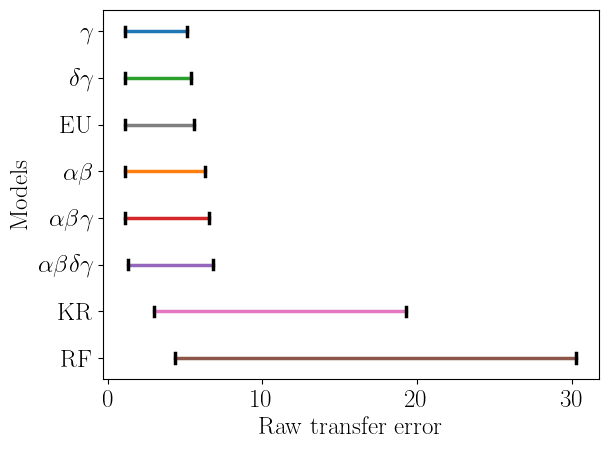

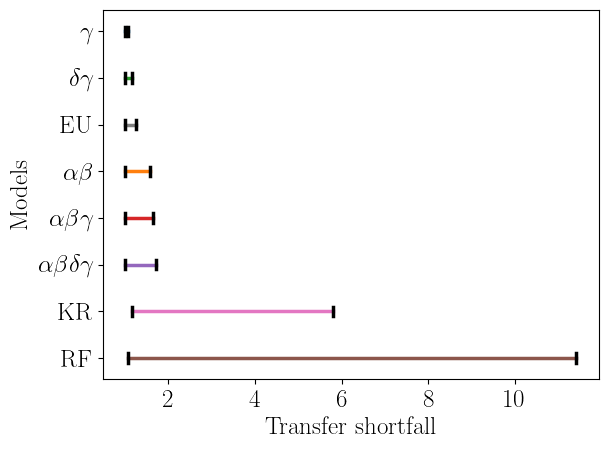

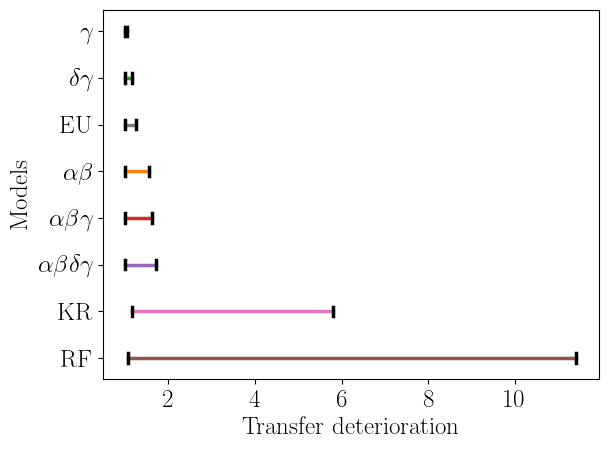

In [57]:
plot_intervals(all_models, raw_transfer_dic, lower_percent=lower_percent, higher_percent=higher_percent, keyword=transfer_error, savepath=f'{fol}/{lower_percent}_{higher_percent}_interval_transfer_error.pdf')
plot_intervals(all_models, best_normalize_dic, lower_percent=lower_percent, higher_percent=higher_percent, keyword=normalized_transfer, savepath=f'{fol}/{lower_percent}_{higher_percent}_interval_normalized_transfer_error.pdf')
plot_intervals(all_models, same_model_normalize_dic, lower_percent=lower_percent, higher_percent=higher_percent, keyword=same_model_transfer, savepath=f'{fol}/{lower_percent}_{higher_percent}_interval_transfer_deterioration.pdf')

# plot_intervals(CPT_models, raw_transfer_dic, lower_percent=lower_percent, higher_percent=higher_percent, keyword=transfer_error, savepath=f'{fol}/CPT_{lower_percent}_{higher_percent}_interval_transfer_error.pdf')
# plot_intervals(CPT_models, best_normalize_dic, lower_percent=lower_percent, higher_percent=higher_percent, keyword=normalized_transfer, savepath=f'{fol}/CPT_{lower_percent}_{higher_percent}_interval_normalized_transfer_error.pdf')
# plot_intervals(CPT_models, same_model_normalize_dic, lower_percent=lower_percent, higher_percent=higher_percent, keyword=same_model_transfer, savepath=f'{fol}/CPT_{lower_percent}_{higher_percent}_interval_transfer_deterioration.pdf')